### Appendix B: VAE Setup


In [2]:
!pip install tensorflow --quiet
!pip install disutils --quiet
!pip install pandas --quiet
!pip install scipy --quiet
!pip install scikit-learn --quiet
!pip install opencv-python --quiet

In [4]:
# Necessary imports

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Layer, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Mean, Metric
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.backend import random_normal

import random 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [5]:
def get_image_data(dir):
    # List to store all image file paths in the given directory.
    all_image_paths = []

    # Loop through all directories and subdirectories in the data directory
    for file in os.listdir(dir):
        if file.endswith(".png"):
            all_image_paths.append(os.path.join(dir, file))
        
    image_count = len(all_image_paths)
    print("Total number of images:", image_count)
    return all_image_paths
    
def initialize_data_gen(IMAGE_DIR, INPUT_SHAPE, BATCH_SIZE):    
    all_image_paths = get_image_data(IMAGE_DIR)
    random.shuffle(all_image_paths) # Shuffle to avoid bias
    image_count = len(all_image_paths)
    
    df_train = pd.DataFrame({'image_paths': all_image_paths[:int(image_count*0.8)]})
    df_test = pd.DataFrame({'image_paths': all_image_paths[int(image_count*0.8):]})

    # Augment the data by adding noise
    train_datagen_args = dict(
        rescale=1.0 / 255, 
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=90,
        width_shift_range=0.1,
        height_shift_range=0.1,
    )
    test_datagen_args = dict(rescale=1.0 / 255)

    # Create the data generators

    print('Starting the data generation')  
    train_datagen = ImageDataGenerator(**train_datagen_args)
    test_datagen = ImageDataGenerator(**test_datagen_args)

    # Use flow_from_dataframe to generate data batches
    train_data_generator = train_datagen.flow_from_dataframe(
        dataframe=df_train,
        color_mode='grayscale',
        x_col='image_paths',
        y_col='image_paths',
        target_size=(INPUT_SHAPE, INPUT_SHAPE),
        batch_size=BATCH_SIZE,
        class_mode='input',  # Set to None since there are no labels
        shuffle=True  # Set to True for randomizing the order of the images
    )

    test_data_generator = test_datagen.flow_from_dataframe(
        dataframe=df_test,
        color_mode='grayscale',
        x_col='image_paths',
        y_col='image_paths',
        target_size=(INPUT_SHAPE, INPUT_SHAPE),  # Specify the desired size of the input images
        batch_size=BATCH_SIZE,
        class_mode='input',  # Set to None since there are no labels
        shuffle=True  # Set to True for randomizing the order of the images
    )

    return df_train, df_test, train_data_generator, test_data_generator

In [6]:
df_train_words, df_test_words, words_train_data_gen, words_test_data_gen = initialize_data_gen('./hw_images/words/', 128, 16)

Total number of images: 15482
Starting the data generation
Found 12385 validated image filenames.
Found 3097 validated image filenames.


### Appendix C: VAE Model

In [7]:
# Define the sampling layer
class Sampling(Layer):
  '''
  Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
  '''

  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = random_normal(shape=(batch, dim))

    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder model

def encoder_model(input_shape, filters, dense_layer_dim, latent_dim):
  '''
  Define the encoder model that maps the image to a lower dimensional space

  '''
  print('Input shape is:', input_shape)
  # Creating the input layer
  inputs = Input(shape=input_shape)
  encoder_layers_dim = []
  encoder_layers_dim.append(tuple(inputs.shape[1:]))

  x = Conv2D(filters[0], (3, 3), activation='relu', strides=2, padding='same')(inputs)
  encoder_layers_dim.append(tuple(x.shape[1:]))

  # Middle layers
  middle_layers = [Conv2D(f, 3, activation='relu', strides=2, padding='same') for f in filters[1:]]

  for mid_layer in middle_layers:
    x = mid_layer(x)
    encoder_layers_dim.append(tuple(x.shape[1:]))

  # Flatten the conv layer output in prep for dense layers
  x = Flatten()(x)
  encoder_layers_dim.append(tuple(x.shape[1:]))

  # Add dense layer with the given dense layer dimension
  x = Dense(dense_layer_dim, activation='relu')(x)

  # Define the latent space
  z_mean = Dense(latent_dim, name='z_mean')(x)
  z_log_var = Dense(latent_dim, name='z_log_var')(x)
  z = Sampling()([z_mean, z_log_var])
  encoder_layers_dim.append(tuple(z.shape[1:]))

  print('Got here with encoder layers dim:', encoder_layers_dim)

  return Model(inputs, [z_mean, z_log_var, z], name='encoder'), encoder_layers_dim

In [8]:
def decoder_model(encoder_layers_dim):
  latent_dim = encoder_layers_dim[-1][0]
  dense_layer_dim = encoder_layers_dim[-2][0]
  first_conv_layer_dim = encoder_layers_dim[-3] # Same as all the middle layers
  output_layer = encoder_layers_dim[0]
  print('Output layer is:', output_layer)

  # Create input layer for latent space
  latent_inputs = Input(shape=(latent_dim,))

  # Number of filters for transposing the convulational layers
  filters = [f[-1] for f in encoder_layers_dim[1:-2]]

  # First dense layer
  x = Dense(dense_layer_dim, activation='relu')(latent_inputs)
  x = Reshape(first_conv_layer_dim)(x)

  # Upsampling
  mid_layers = [Conv2DTranspose(f, 3, activation="relu", strides=2, padding="same") for f in filters[::-1]]
  for mid_layer in mid_layers:
      x = mid_layer(x)

  # Apply final convolutional layer with sigmoid activation to output reconstructed image
  decoder_outputs = Conv2DTranspose(output_layer[-1], 3, activation="sigmoid", padding="same")(x)
  print('Decoder outputs:', decoder_outputs.shape)

  # Create and return Keras model with latent vector as input and reconstructed image as output
  return Model(latent_inputs, decoder_outputs, name="decoder")

In [9]:
class VAE(Model):
  
  def __init__(self, encoder, decoder, **kwargs):
    super().__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder

    # Metrics we'll track during training
    self.total_loss_tracker = Mean(name="total_loss")
    self.reconstruction_loss_tracker = Mean(name="reconstruction_loss")
    self.kl_loss_tracker = Mean(name="kl_loss")

    # Metrics we'll track during validation
    self.val_total_loss_tracker = Mean(name="val_total_loss")
    self.val_reconstruction_loss_tracker = Mean(name="val_reconstruction_loss")
    self.val_kl_loss_tracker = Mean(name="val_kl_loss")

  @property
  def metrics(self):
    return [
        self.total_loss_tracker,
        self.reconstruction_loss_tracker,
        self.kl_loss_tracker,
        self.val_total_loss_tracker,
        self.val_reconstruction_loss_tracker,
        self.val_kl_loss_tracker,
    ]

  # Define forward pass
  def call(self, input):
    z_mean, z_log_var, z = self.encoder(input)
    reconstruction = self.decoder(z)
    return z_mean, z_log_var, z, reconstruction

  # Training step
  def train_step(self, data):
    with tf.GradientTape() as tape:
      # Forward pass
      z_mean, z_log_var, z, reconstruction = self(data[0])

      # Compute reconstruction loss
      reconstruction_loss = tf.reduce_mean(
          tf.reduce_sum(
              tf.keras.losses.binary_crossentropy(data[0], reconstruction), axis=(1, 2)
          ))

      # Compute KL divergence loss
      kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
      kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

      # Compute total loss
      total_loss = reconstruction_loss + kl_loss

    # Compute gradients
    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    # Update metrics
    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)

    return {
        "loss": self.total_loss_tracker.result(),
        "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        "kl_loss": self.kl_loss_tracker.result(),
    }

  def test_step(self, data):
    # Forward pass through encoder and decoder
    z_mean, z_log_var, z, reconstruction = self(data[0])

    # Compute reconstruction loss
    reconstruction_loss = tf.reduce_mean(
        tf.reduce_sum(
            binary_crossentropy(data[0], reconstruction), axis=(1, 2)
        )
    )

    # Compute KL divergence loss
    kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

    # Compute total loss
    total_loss = reconstruction_loss + kl_loss
    self.val_total_loss_tracker.update_state(total_loss)
    self.val_reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.val_kl_loss_tracker.update_state(kl_loss)

    return {
        "loss": self.val_total_loss_tracker.result(),
        "reconstruction_loss": self.val_reconstruction_loss_tracker.result(),
        "kl_loss": self.val_kl_loss_tracker.result(),
    }

  def on_epoch_end(self):
    self.total_loss_tracker.reset_states()
    self.reconstruction_loss_tracker.reset_states()
    self.kl_loss_tracker.reset_states()
    self.val_total_loss_tracker.reset_states()
    self.val_reconstruction_loss_tracker.reset_states()
    self.val_kl_loss_tracker.reset_states()


In [10]:
class VAECallback(Callback):
    """
    Randomly sample 5 images from validation_data set and shows the reconstruction after each epoch
    """
    def __init__(self, vae, validation_data, log_dir, n=5):
        self.vae = vae
        self.validation_data = validation_data
        self.n = n
        self.log_dir = log_dir

    def on_epoch_end(self, epoch, logs=None):
        # check every 10 epochs
        if epoch % 10 ==0:
            # Generate decoded images from the validation input
            validation_batch = next(iter(self.validation_data))
            _, _, _, reconstructed_images = self.vae.predict(validation_batch[0])

            # Rescale pixel values to [0, 1]
            reconstructed_images = np.clip(reconstructed_images, 0.0, 1.0)

            # Plot the original and reconstructed images side by side
            plt.figure(figsize=(10, 2*self.n))  # Adjusted the figure size
            for i in range(self.n):
                plt.subplot(self.n, 2, 2*i+1)
                plt.imshow(validation_batch[0][i], cmap='gray')
                plt.axis('off')
                plt.subplot(self.n, 2, 2*i+2)
                plt.imshow(reconstructed_images[i], cmap='gray')
                plt.axis('off')
            fig_name = os.path.join(self.log_dir , 'decoded_images_epoch_{:04d}.png'.format(epoch))
            plt.savefig(fig_name)
            # plt.show()

In [11]:
class TotalLoss(Metric):
    '''
    Custom metric to compute the total loss. Used to track model's performance for early stopping.
    '''

    def __init__(self, name="total_loss", **kwargs):
        super().__init__(name=name, **kwargs)
        self.total_loss = self.add_weight(name="tl", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Compute the total loss
        z_mean, z_log_var, z, reconstruction = y_pred
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                binary_crossentropy(y_true, reconstruction), axis=(1, 2)
            )
        )
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss

        self.total_loss.assign(total_loss)

    def result(self):
        return self.total_loss

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.total_loss.assign(0.)

### Appendix D: VAE Training

In [12]:
# Training and testing
import pandas as pd
import random

def test_data_and_train(train_data_generator, test_data_generator, EPOCHS, LEARNING_RATE, LOGDIR, INPUT_SHAPE, FILTERS, DENSE_LAYER_DIM, LATENT_DIM):
    # Create the model
    encoder, encoder_layers_dim = encoder_model(input_shape = (INPUT_SHAPE,INPUT_SHAPE, 1), filters=FILTERS, dense_layer_dim=DENSE_LAYER_DIM, latent_dim=LATENT_DIM)
    print('Encoder:', encoder.summary())
    print('Encoder layers:', encoder_layers_dim)
    decoder = decoder_model(encoder_layers_dim)
    print('Decoder:', decoder.summary())
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=Adam(learning_rate=LEARNING_RATE), metrics=[TotalLoss()])

    # Callbacks
    vae_callback = VAECallback(vae, test_data_generator, LOGDIR)
    tensorboard_cb = TensorBoard(log_dir=LOGDIR, histogram_freq=1)
    vae_path = os.path.join(LOGDIR, "vae")

    # Check if vae_path exists, if not create it
    if not os.path.exists(vae_path):
        os.mkdir(vae_path)

    checkpoint_cb = ModelCheckpoint(filepath=os.path.join(vae_path, 'checkpoints.weights.h5'), save_weights_only=True, verbose=1)

    earlystopping_cb = EarlyStopping(
        monitor="reconstruction_loss",
        mode='min',
        min_delta=1e-2,
        patience=5,
        verbose=1,
    )

    words_history = vae.fit(
        train_data_generator,
        epochs=EPOCHS,
        validation_data=test_data_generator,
        callbacks=[tensorboard_cb, vae_callback, checkpoint_cb, earlystopping_cb]
    )

    return words_history, vae

In [15]:
# Train the model for words in the hw_images directory
# Runs in 85 minutes

IMAGE_DIR = './hw_images/words'
INPUT_SHAPE = 128
FILTERS = [16, 32, 64]
DENSE_LAYER_DIM = 512
LATENT_DIM = 64
BATCH_SIZE = 16
EPOCHS = 30
LEARNING_RATE = 0.001
LOGDIR = './word_logs1'


words_history, words_vae = test_data_and_train(words_train_data_gen, words_test_data_gen, EPOCHS, LEARNING_RATE, LOGDIR, INPUT_SHAPE, FILTERS, DENSE_LAYER_DIM, LATENT_DIM)
tf.saved_model.save_weights(words_vae, './models/words_vae.weights.h5')

Input shape is: (128, 128, 1)
Got here with encoder layers dim: [(128, 128, 1), (64, 64, 16), (32, 32, 32), (16, 16, 64), (16384,), (64,)]


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │        160 │ input_layer_4[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │      4,640 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │     18,496 │ conv2d_7[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 16384)     │          0 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │  8,389,120 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 64)        │     32,832 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 64)        │     32,832 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_2          │ (None, 64)        │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,478,080 (32.34 MB)

 Trainable params: 8,478,080 (32.34 MB)

 Non-trainable params: 0 (0.00 B)

Encoder: None
Encoder layers: [(128, 128, 1), (64, 64, 16), (32, 32, 32), (16, 16, 64), (16384,), (64,)]
Output layer is: (128, 128, 1)
Decoder outputs: (None, 128, 128, 1)


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16384)          │     1,064,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 32, 32, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 128, 128, 16)   │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 128, 128, 1)    │           145 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,125,121 (4.29 MB)

 Trainable params: 1,125,121 (4.29 MB)

 Non-trainable params: 0 (0.00 B)

Decoder: None


ValueError: Unrecognized data type: x=./hw_images/words (of type <class 'str'>)

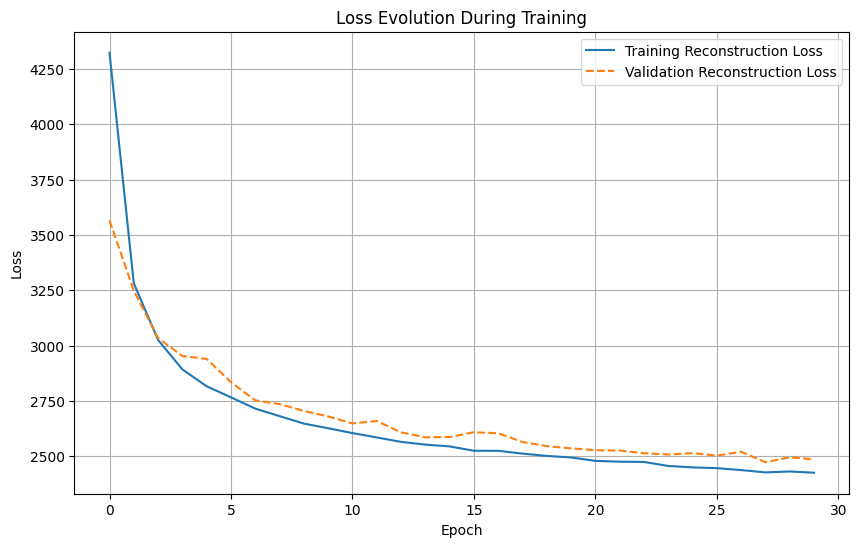

In [13]:
import matplotlib.pyplot as plt

# Extract the loss values from the history object
train_loss = words_history.history['reconstruction_loss']
val_loss = words_history.history['val_reconstruction_loss']  # Use the appropriate key if different

# Plot the training and validation loss evolution
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Reconstruction Loss')
plt.plot(val_loss, label='Validation Reconstruction Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Evolution During Training')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
df_test_char, df_train_char, char_train_data_gen, char_test_data_gen = initialize_data_gen('./hw_images/characters/', 128, 16)

Total number of images: 44074
Starting the data generation
Found 35259 validated image filenames.
Found 8815 validated image filenames.


Total number of images: 44074
Input shape is: (128, 128, 1)
Got here with encoder layers dim: [(128, 128, 1), (64, 64, 16), (32, 32, 32), (16, 16, 64), (16384,), (64,)]


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 64, 64,    │        160 │ input_layer_8[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 32, 32,    │      4,640 │ conv2d_12[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 16, 16,    │     18,496 │ conv2d_13[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 16384)     │          0 │ conv2d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 512)       │  8,389,120 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 64)        │     32,832 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 64)        │     32,832 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_4          │ (None, 64)        │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,478,080 (32.34 MB)

 Trainable params: 8,478,080 (32.34 MB)

 Non-trainable params: 0 (0.00 B)

Encoder: None
Encoder layers: [(128, 128, 1), (64, 64, 16), (32, 32, 32), (16, 16, 64), (16384,), (64,)]
Output layer is: (128, 128, 1)
Decoder outputs: (None, 128, 128, 1)


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16384)          │     1,064,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_16             │ (None, 32, 32, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_17             │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_18             │ (None, 128, 128, 16)   │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_19             │ (None, 128, 128, 1)    │           145 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,125,121 (4.29 MB)

 Trainable params: 1,125,121 (4.29 MB)

 Non-trainable params: 0 (0.00 B)

Decoder: None


/Users/wisdom/Downloads/CS156 ML Assignment/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - kl_loss: 125.5635 - loss: 4689.0747 - reconstruction_loss: 4563.5068

/Users/wisdom/Downloads/CS156 ML Assignment/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step

Epoch 1: saving model to ./char_logs/vae/checkpoints.weights.h5
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 2079s 942ms/step - kl_loss: 125.5747 - loss: 4688.4619 - reconstruction_loss: 4562.8828 - val_kl_loss: 169.9446 - val_loss: 2475.6140 - val_reconstruction_loss: 2305.6704
Epoch 2/10
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - kl_loss: 165.2917 - loss: 2380.9128 - reconstruction_loss: 2215.6201
Epoch 2: saving model to ./char_logs/vae/checkpoints.weights.h5
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 3090s 1s/step - kl_loss: 165.2918 - loss: 2380.8901 - reconstruction_loss: 2215.5974 - val_kl_loss: 160.6542 - val_loss: 2297.9070 - val_reconstruction_loss: 2137.2522
Epoch 3/10
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - kl_loss: 166.5109 - loss: 2229.2043 - reconstruction_loss: 2062.6953
Epoch 3: saving model to ./char_logs/vae/checkpoints.weights.h5
2204/2204 ━━━━━━━━━━━━━━━━━━━━ 483s 219ms/step - kl_loss: 166.5111 - loss: 2229.1938 - reconstruction_loss: 2062.684

TypeError: this __dict__ descriptor does not support '_DictWrapper' objects

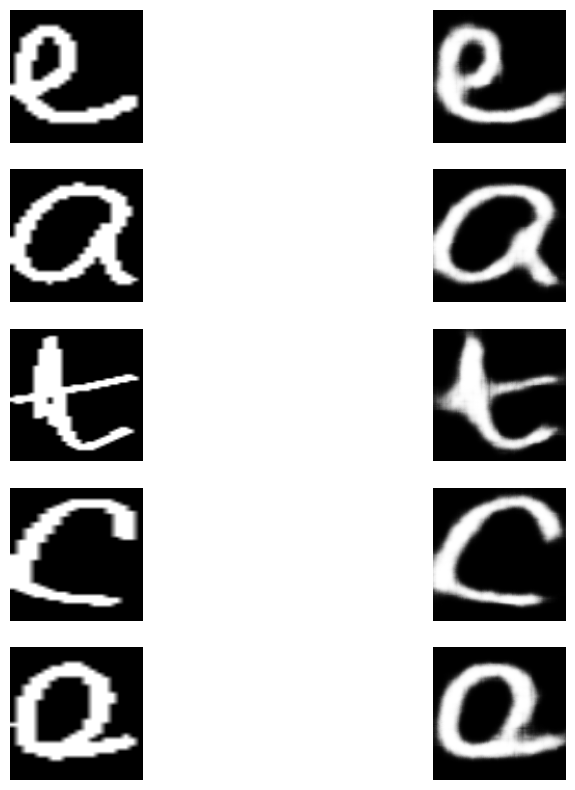

In [18]:
IMAGE_DIR = './hw_images/characters'
all_image_paths = get_image_data(IMAGE_DIR)
INPUT_SHAPE = 128
FILTERS = [16, 32, 64]
DENSE_LAYER_DIM = 512
LATENT_DIM = 64
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 0.001
LOGDIR = './char_logs'

char_history, char_vae = test_data_and_train(char_train_data_gen, char_test_data_gen, EPOCHS, LEARNING_RATE, LOGDIR, INPUT_SHAPE, FILTERS, DENSE_LAYER_DIM, LATENT_DIM)
char_vae.save_weights('./models/char_vae.weights.h5')

In [23]:
char_vae.save_weights('./models/char_vae.weights.h5')

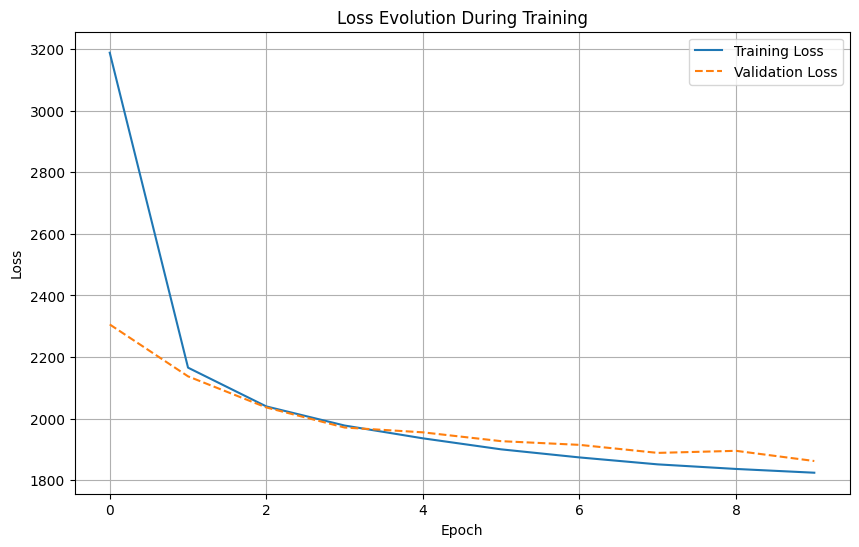

In [25]:
import matplotlib.pyplot as plt

# Extract the loss values from the history object
train_loss = char_history.history['reconstruction_loss']
val_loss = char_history.history['val_reconstruction_loss']  # Use the appropriate key if different

# Plot the training and validation loss evolution
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Evolution During Training')
plt.legend()
plt.grid(True)
plt.show()


### Appendix E: VAE Generation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


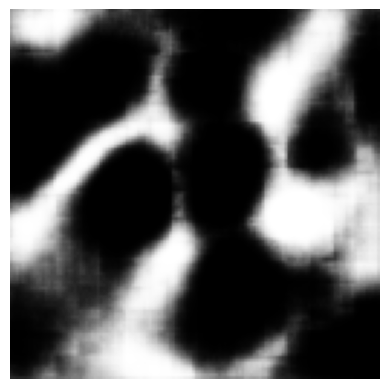

In [26]:
# Generate a new image

def generate_image(vae, latent_dim):
    # Generate a random latent space
    latent_space = np.random.normal(size=(1, latent_dim))
    # Decode the latent space
    generated_image = vae.decoder.predict(latent_space)
    # Rescale pixel values to [0, 1]
    generated_image = np.clip(generated_image, 0.0, 1.0)
    # Plot the generated image
    plt.imshow(generated_image[0], cmap='gray')
    plt.axis('off')
    plt.show()

generate_image(char_vae, LATENT_DIM)

551/551 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step


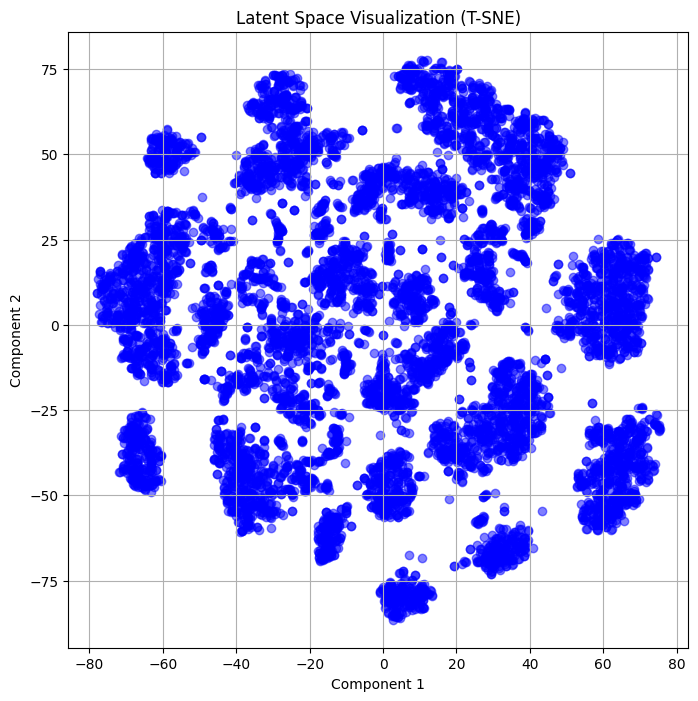

In [27]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

# Encode input images into latent representations
latent_representations, _, _ = char_vae.encoder.predict(char_test_data_gen)

# Alternatively, use t-SNE for nonlinear relationships
latent_2d = TSNE(n_components=2, random_state=42).fit_transform(latent_representations)

# Visualize the latent space
plt.figure(figsize=(8, 8))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c='blue', alpha=0.5)
plt.title("Latent Space Visualization (T-SNE)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal, kl_divergence
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans

class SmartSampler:
    def __init__(self, vae, latent_dim):
        self.vae = vae
        self.latent_dim = latent_dim
        self.kde = None
        self.kmeans = None
        
    def fit_density_estimators(self, latent_vectors):
        """Fit KDE and KMeans to the latent vectors"""
        self.kde = KernelDensity(bandwidth=0.1).fit(latent_vectors)
        self.kmeans = KMeans(n_clusters=10).fit(latent_vectors)
        
    def random_sampling(self, n_samples):
        """Basic random sampling from normal distribution"""
        return torch.randn(n_samples, self.latent_dim)
    
    def kde_sampling(self, n_samples, threshold=-5):
        """Sample using KDE-based rejection sampling"""
        if self.kde is None:
            raise ValueError("Must call fit_density_estimators first!")
            
        accepted_samples = []
        while len(accepted_samples) < n_samples:
            candidates = np.random.normal(0, 1, size=(n_samples * 2, self.latent_dim))
            densities = self.kde.score_samples(candidates)
            accepted = candidates[densities > threshold]
            accepted_samples.extend(accepted[:n_samples - len(accepted_samples)])
            
        return torch.tensor(accepted_samples[:n_samples]).float()
    
    def cluster_based_sampling(self, n_samples, std_dev=0.1):
        """Sample near cluster centers"""
        if self.kmeans is None:
            raise ValueError("Must call fit_density_estimators first!")
            
        centers = self.kmeans.cluster_centers_
        samples = []
        
        for _ in range(n_samples):
            center_idx = np.random.randint(len(centers))
            center = centers[center_idx]
            sample = center + np.random.normal(0, std_dev, size=self.latent_dim)
            samples.append(sample)
            
        return torch.tensor(samples).float()
    
    def interpolation_sampling(self, n_samples, latent_representations, n_interpolations=10):
        """Sample by interpolating between random training points"""
        if len(latent_representations) == 0:
            raise ValueError("No training latents available!")
            
        latents = np.vstack(latent_representations)
        samples = []
        
        while len(samples) < n_samples:
            idx1, idx2 = np.random.choice(len(latents), 2, replace=False)
            p1, p2 = latents[idx1], latents[idx2]
            
            # Linear interpolation
            alphas = np.linspace(0, 1, n_interpolations)
            interpolated = np.array([p1 * (1-alpha) + p2 * alpha for alpha in alphas])
            samples.extend(interpolated)
            
        return torch.tensor(samples[:n_samples]).float()

# Example usage
def generate_samples(vae, sampler, latent_representations = None, n_samples=10, method='kde'):
    with torch.no_grad():
        # Choose sampling method
        if method == 'kde':
            z = sampler.kde_sampling(n_samples)
        elif method == 'cluster':
            z = sampler.cluster_based_sampling(n_samples)
        elif method == 'interpolation':
            z = sampler.interpolation_sampling(n_samples, latent_representations=latent_representations)
        else:
            z = sampler.random_sampling(n_samples)
            
        # Generate samples
        samples = vae.decoder(z)
        return samples

# Example setup and training
# Setup sampler
sampler = SmartSampler(char_vae, LATENT_DIM)
sampler.fit_density_estimators(np.vstack(latent_representations))

# Generate samples using different methods
kde_samples = generate_samples(char_vae, sampler, method='kde')
cluster_samples = generate_samples(char_vae, sampler, method='cluster')
interpolated_samples = generate_samples(char_vae, sampler, latent_representations=latent_representations, method='interpolation')

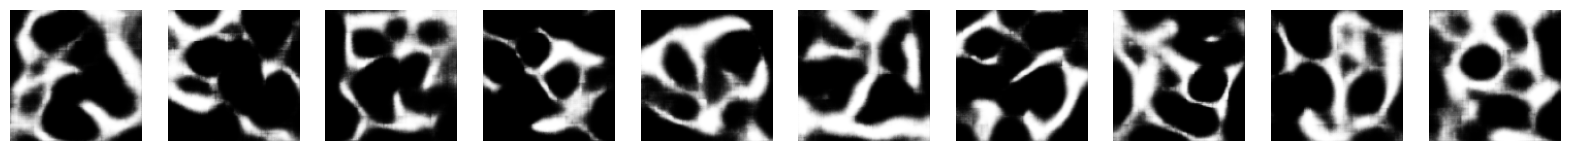

In [29]:
# Visualize samples

def visualize_samples(samples, n_samples=10):
    fig, axes = plt.subplots(1, n_samples, figsize=(20, 2))
    for i in range(n_samples):
        axes[i].imshow(samples[i].numpy().squeeze(), cmap='gray')
        axes[i].axis('off')
    plt.show()


visualize_samples(kde_samples)


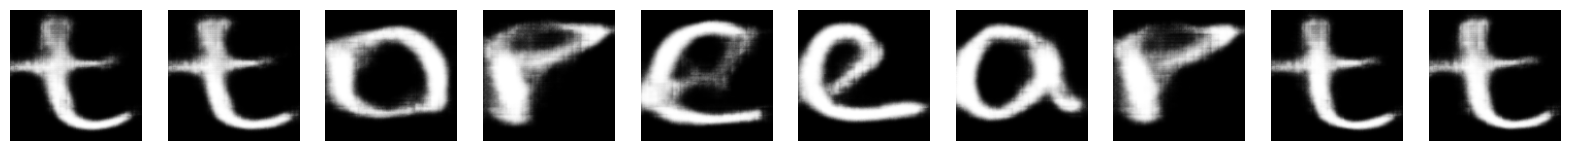

In [30]:
visualize_samples(cluster_samples)

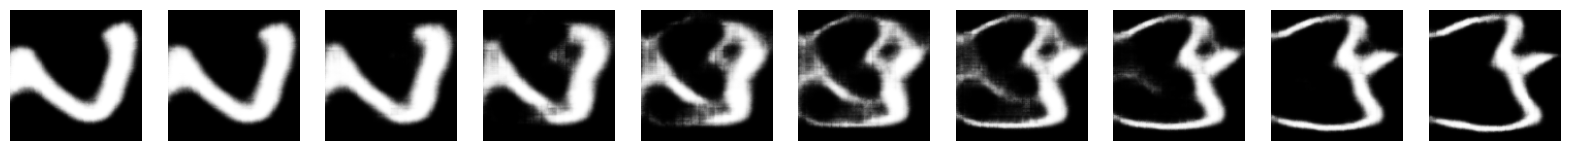

In [33]:
visualize_samples(interpolated_samples)

### Appendix F: Semi-supervised Labeling

In [71]:
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output

def analyze_clusters_interactive(latent_representations, vae, latent_2d, dbscan_eps, dbscan_samples, samples_per_cluster=5):
    """
    Analyze clusters in the latent space and allow interactive labeling
    
    Args:
        latent_representations: Array of latent vectors
        vae: Trained VAE model
        samples_per_cluster: Number of samples to show per cluster
    """
    
    # Use DBSCAN for density-based clustering
    print("Identifying clusters...")
    dbscan = DBSCAN(eps=dbscan_eps, min_samples=dbscan_samples)
    cluster_labels = dbscan.fit_predict(latent_2d)
    
    # Get unique clusters (excluding noise points labeled as -1)
    unique_clusters = np.unique(cluster_labels)
    unique_clusters = unique_clusters[unique_clusters != -1]
    
    print(f"Found {len(unique_clusters)} clusters")
    
    # Store results
    cluster_samples = {}
    
    # Process one cluster at a time
    for i in unique_clusters:
        # Get indices of points in this cluster
        cluster_indices = np.where(cluster_labels == i)[0]
        
        # Get sample latent vectors from this cluster
        sample_indices = random.sample(list(cluster_indices), 
                                     min(samples_per_cluster, len(cluster_indices)))
        sample_latents = latent_representations[sample_indices]
        
        # Generate images from these latent vectors
        generated_images = vae.decoder.predict(sample_latents)
        
        # Create a new figure for this cluster
        plt.figure(figsize=(15, 3))
        
        # Visualize samples from this cluster
        for j, img in enumerate(generated_images):
            plt.subplot(1, samples_per_cluster, j + 1)
            plt.imshow(img.squeeze(), cmap='gray')
            plt.axis('off')
        
        plt.suptitle(f'Cluster {i} - Press Enter to continue, type "discard" to skip this cluster')
        plt.show()
        
        # Get user input for this cluster
        label = input(f"Enter label for cluster {i} (or 'discard' to skip): ")
        
        if label.lower() != 'discard':
            cluster_samples[i] = {
                'label': label,
                'sample_indices': sample_indices,
                'latent_vectors': sample_latents
            }
        
        plt.close()
        clear_output(wait=True)
    
    # Visualize final clustering results
    plt.figure(figsize=(10, 10))
    for i in cluster_samples:
        mask = cluster_labels == i
        plt.scatter(latent_2d[mask, 0], latent_2d[mask, 1], label=f'{cluster_samples[i]["label"]}')
    
    plt.title('T-SNE visualization of clusters with labels')
    plt.legend()
    plt.show()
    
    return cluster_labels, cluster_samples

In [81]:
import json
def save_labeled_dataset(cluster_labels, cluster_samples, latent_representations, vae, output_dir='labeled_dataset'):
    """
    Save all labeled images and create a dataset mapping, combining clusters with the same label
    
    Args:
        cluster_labels: Array of cluster labels for all data points
        cluster_samples: Dictionary of labeled clusters
        latent_representations: Original latent vectors for all data points
        vae: Trained VAE model
        output_dir: Directory to save the dataset
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    dataset_mapping = {}

    def sanitize_label(label):
        label_map = {
            '/': 'slash',
            '\\': 'backslash',
            ':': 'colon',
            '*': 'star',
            '?': 'question',
            '"': 'quote',
            '<': 'less',
            '>': 'greater',
            '|': 'pipe',
            ' ': '_'
        }
        return label_map.get(label, label)
    
    # First, create a mapping from labels to cluster IDs
    label_to_clusters = {}
    for cluster_id, info in cluster_samples.items():
        label = info['label']
        safe_label = sanitize_label(label)
        if safe_label not in label_to_clusters:
            label_to_clusters[safe_label] = []
        label_to_clusters[safe_label].append(int(cluster_id))
    
    # Process each point in the dataset
    for idx, (cluster_id, latent_vector) in enumerate(zip(cluster_labels, latent_representations)):
        # Skip if the cluster was discarded or marked as noise (-1)
        if cluster_id == -1 or cluster_id not in [int(k) for k in cluster_samples.keys()]:
            continue
            
        # Get label for this cluster
        label = cluster_samples[cluster_id]['label']
        safe_label = sanitize_label(label)
        
        # Create directory for this character if it doesn't exist
        char_dir = os.path.join(output_dir, safe_label)
        os.makedirs(char_dir, exist_ok=True)
        
        # Generate image from latent vector
        generated_image = vae.decoder.predict(latent_vector[np.newaxis, :])
        
        # Save image
        img_path = os.path.join(char_dir, f'2_{safe_label}_{idx}.png')
        plt.imsave(img_path, generated_image.squeeze(), cmap='gray')
        dataset_mapping[img_path] = safe_label
    
    # Save dataset mapping
    with open(os.path.join(output_dir, 'dataset_mapping2.json'), 'w') as f:
        json.dump(dataset_mapping, f, indent=2)
        
    print(f"Saved {len(dataset_mapping)} images across {len(label_to_clusters)} unique characters")
    
    # Print distribution of labels and their clusters
    print("\nDistribution of labels:")
    for label, cluster_ids in sorted(label_to_clusters.items()):
        count = sum(1 for path, l in dataset_mapping.items() if l == label)
        print(f"{label}: {count} images (from clusters {cluster_ids})")

    return label_to_clusters, dataset_mapping, cluster_samples

In [ ]:
# Labelling the test dataset (interactive)

cluster_labels, cluster_samples = analyze_clusters_interactive(latent_representations, char_vae)

In [ ]:
# After running the interactive clustering
save_labeled_dataset(cluster_labels, cluster_samples, latent_representations, char_vae)

Starting the data generation
Found 35259 validated image filenames.


/Users/wisdom/Downloads/CS156 ML Assignment/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2204/2204 ━━━━━━━━━━━━━━━━━━━━ 51s 23ms/step


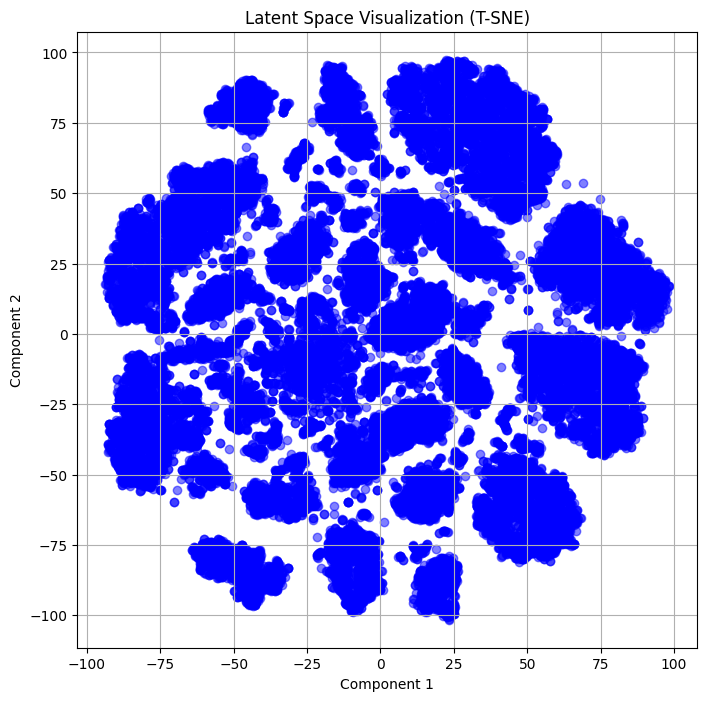

In [69]:
# For the train dataset, we can use the same approach as the test dataset. 

# Reset the training data generator to remove all data augmentation
train_datagen_args = dict(rescale=1.0 / 255)

# Create the data generators
print('Starting the data generation')  
train_datagen = ImageDataGenerator(**train_datagen_args)

# Use flow_from_dataframe to generate data batches
char_train_data_gen = train_datagen.flow_from_dataframe(
    dataframe=df_test_char,
    color_mode='grayscale',
    x_col='image_paths',
    y_col='image_paths',
    target_size=(INPUT_SHAPE, INPUT_SHAPE),
    batch_size=BATCH_SIZE,
    class_mode='input',  # Set to None since there are no labels
    shuffle=True  # Set to True for randomizing the order of the images
)

latent_representations, _, _ = char_vae.encoder.predict(char_train_data_gen)
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_representations)

# Visualize the latent space
plt.figure(figsize=(8, 8))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c='blue', alpha=0.5)
plt.title("Latent Space Visualization (T-SNE)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid()
plt.show()

In [ ]:
cluster_labels, cluster_samples = analyze_clusters_interactive(latent_representations, char_vae, latent_2d, 0.3, 5)

In [82]:
label_to_clusters, dataset_mapping, cluster_samples = save_labeled_dataset(cluster_labels, cluster_samples, latent_representations, char_vae)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━